# Load tfrecords, define model and train

In [24]:
# Dependencies

 # TensorFlow and tf.keras
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)
from tensorflow import keras
from keras import layers
from keras import models

# Helper libraries
import os
import os.path
import glob
import librosa
import librosa.display
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as pd
import pprint

# Check if the GPU is available (otherwise computing will take a looooonnnnggggg time)
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")



Tensorflow Version: 2.9.1
GPU not available :(


In [33]:
# load global settings in config-dictionary
with open('./MA_CONFIG.json', 'r') as fp:
  config = json.load(fp)

# define some extra values
config['batch_size'] = 16
config['shuffle_buffer_size'] = 300
config['n_epochs'] = 10
config['train_dataset_path'] = '../Dataset/train.tfrecord'
config['test_dataset_path'] = '../Dataset/test.tfrecord'


# print config
print(json.dumps(config, indent=4))

# save config to disk
with open('./MA_CONFIG.json', 'w+') as fp:
    json.dump(config, fp, sort_keys=True, indent=4)


{
    "batch_size": 16,
    "fps_noisy": "/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/noisySpeech",
    "fps_produced": "/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/producedSpeech",
    "fps_voicefixer": "/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/voicefixerOutput",
    "hop_length": 64,
    "input_shape": [
        441000,
        1
    ],
    "n_epochs": 10,
    "n_fft": 512,
    "n_mels": 16,
    "offset": 6,
    "sample_length": 20,
    "shuffle_buffer_size": 300,
    "sr": 44100,
    "test_dataset_path": "../Dataset/test.tfrecord",
    "train_dataset_path": "../Dataset/train.tfrecord",
    "win_length": 512
}


# load datasets

In [26]:
# load datasets from disk
train_dataset = tf.data.experimental.load(config['train_dataset_path'],
                                   (tf.TensorSpec(shape=(441000, 1),
                                                   dtype=tf.float32, name=None),
                                     tf.TensorSpec(shape=(441000, 1),
                                                  dtype=tf.float32, name=None)),
                                                   compression='GZIP')

test_dataset = tf.data.experimental.load(config['test_dataset_path'],
                                      (tf.TensorSpec(shape=(441000, 1),
                                                        dtype=tf.float32, name=None),
                                        tf.TensorSpec(shape=(441000, 1),
                                                        dtype=tf.float32, name=None)),
                                                        compression='GZIP')




# count elements in train-dataset and save to config
i = 0
for d in train_dataset:
    i = i + 1
print(f'Number of elements in train-dataset: {i}')

# count elements in test-dataset and save to config
i = 0
for d in test_dataset:
    i = i + 1
print(f'Number of elements in test-dataset: {i}')


# batching and shuffling
train_dataset = train_dataset.shuffle(config['shuffle_buffer_size']).batch(config['batch_size'])
test_dataset = test_dataset.shuffle(config['shuffle_buffer_size']).batch(config['batch_size'])




Number of elements in train-dataset: 65
Number of elements in test-dataset: 53


In [27]:
# check if datasets are loaded correctly
for d in train_dataset:
    print(d[0].shape)
    print(d[1].shape)
    break   

for d in test_dataset:
    print(d[0].shape)
    print(d[1].shape)
    break



(16, 441000, 1)
(16, 441000, 1)
(16, 441000, 1)
(16, 441000, 1)


# look at data

In [ ]:
# look at some example data from train dataset
wavs = train_dataset.unbatch().as_numpy_iterator()
noisy = []
gt = []

# Setup Subplot
nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(16, 9))


# iterate over dataset
for i, sample in enumerate(wavs):
    
    # get the column and row by modulo and remainder
    j = i % ncols
    k = int(i / ncols)
    
    # extract noisy and produced speech file from tensors
    wave = sample[0]
    ground_truth = sample[1]
        
    # plot files
    librosa.display.waveshow(np.squeeze(wave), x_axis='time', sr=config['sr'], ax=ax[k][j], label='test_file')
    librosa.display.waveshow(np.squeeze(ground_truth), alpha=0.3, x_axis='time', sr=config['sr'], ax=ax[k][j], label='ground_truth')
    ax[k][j].legend()
    ax[k][j].axis('on')
    ax[k][j].set_title('10s speech')  

    # save speech to arrays
    noisy.append(np.squeeze(wave))
    gt.append(np.squeeze(ground_truth))
    
    if i+1 == ncols*nrows:
        break
    
# adjust whitespace in between subplots        
plt.subplots_adjust(hspace=0.25, wspace=0.15)
plt.show()


# listen to the audio samples
for i in range(len(gt)):
    print(f'----------- {i+1}. speechsnippet ---------------')
    print('')
    print(f'Voicefixer file')
    pd.display(pd.Audio(noisy[i].T, rate=config['sr']))
    print(f'corresponding produced file')
    pd.display(pd.Audio(gt[i].T, rate=config['sr']))
    print('')

## Model architecture

In [29]:
input_shape = (441000, 1)
output_channels = 1

filter_size = 8
kernel_size = 2

# build model with 12 layers
def build_model(input_shape):

    # define model
    model = keras.Sequential(name='PostNet_Conv1D')
    model.add(keras.Input(shape=input_shape))

    # add layer 
    model.add(keras.layers.Conv1D(filters=filter_size, kernel_size=kernel_size, padding='same'))
    model.add(keras.layers.Activation('tanh'))

    # Add the remaining Conv1D layers
    for _ in range(11):
        model.add(keras.layers.Conv1D(filters=filter_size, kernel_size=kernel_size, padding='same'))
        model.add(keras.layers.Activation('tanh'))

    # Add the final Conv1D layer
    model.add(keras.layers.Conv1D(filters=output_channels, kernel_size=1, padding='same'))
    model.add(keras.layers.Activation('tanh'))

    return model

In [1]:
# get model
model = build_model(input_shape = input_shape)




# define metrics to monitor mse
metrics = [tf.keras.losses.MeanSquaredError()]

# Set up optimizer with high initial learning rate
opt = keras.optimizers.Adam(learning_rate=0.06)

# define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoint',
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1),
]   

# compile model
model.compile(optimizer=opt,
              loss=tf.keras.losses.MeanAbsolutePercentageError(),
              metrics=metrics)

model.summary()

NameError: name 'build_model' is not defined

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 2075769.3750 - mean_squared_error: 0.0695
Epoch 1: val_loss did not improve from 3845867.50000
5/5 [==============================] - 20s 4s/step - loss: 2075769.3750 - mean_squared_error: 0.0695 - val_loss: 4667504.5000 - val_mean_squared_error: 0.1475
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 1479772.1250 - mean_squared_error: 0.0513
Epoch 2: val_loss improved from 3845867.50000 to 193874.28125, saving model to ./model_checkpoint


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


5/5 [==============================] - 22s 4s/step - loss: 1479772.1250 - mean_squared_error: 0.0513 - val_loss: 193874.2812 - val_mean_squared_error: 0.0149
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 586458.3125 - mean_squared_error: 0.0253
Epoch 3: val_loss did not improve from 193874.28125
5/5 [==============================] - 20s 4s/step - loss: 586458.3125 - mean_squared_error: 0.0253 - val_loss: 2080886.3750 - val_mean_squared_error: 0.0411
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 1119860.6250 - mean_squared_error: 0.0339
Epoch 4: val_loss did not improve from 193874.28125
5/5 [==============================] - 20s 4s/step - loss: 1119860.6250 - mean_squared_error: 0.0339 - val_loss: 978116.0000 - val_mean_squared_error: 0.0214
Epoch 5/10
5/5 [==============================] - ETA: 0s - loss: 538236.1250 - mean_squared_error: 0.0320
Epoch 5: val_loss did not improve from 193874.28125
5/5 [==============================] - 20s 4s/st

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


5/5 [==============================] - 21s 4s/step - loss: 969581.8750 - mean_squared_error: 0.0332 - val_loss: 162685.9688 - val_mean_squared_error: 0.0149
Epoch 7/10
5/5 [==============================] - ETA: 0s - loss: 1068629.7500 - mean_squared_error: 0.0386
Epoch 7: val_loss did not improve from 162685.96875
5/5 [==============================] - 19s 4s/step - loss: 1068629.7500 - mean_squared_error: 0.0386 - val_loss: 1471148.3750 - val_mean_squared_error: 0.0292
Epoch 8/10
5/5 [==============================] - ETA: 0s - loss: 797225.5000 - mean_squared_error: 0.0323
Epoch 8: val_loss did not improve from 162685.96875
5/5 [==============================] - 20s 4s/step - loss: 797225.5000 - mean_squared_error: 0.0323 - val_loss: 1435257.2500 - val_mean_squared_error: 0.0282
Epoch 9/10
5/5 [==============================] - ETA: 0s - loss: 899382.2500 - mean_squared_error: 0.0564
Epoch 9: val_loss did not improve from 162685.96875
5/5 [==============================] - 19s 4s/st

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


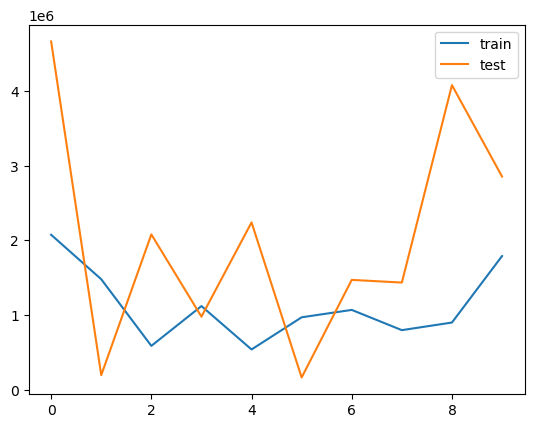

In [34]:
# fit model
history = model.fit(train_dataset,
                    epochs=config['n_epochs'],
                    validation_data=test_dataset,
                    callbacks=callbacks)

# save model
model.save('./model')

# save history
with open('./history.json', 'w+') as fp:
    json.dump(history.history, fp, sort_keys=True, indent=4)



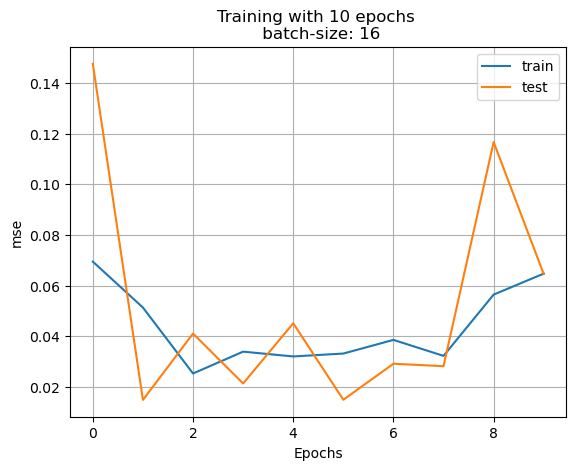

In [41]:
# plot mse
train_mse = history.history['mean_squared_error']
eval_mse = history.history['val_mean_squared_error']

fig2 = plt.figure()
plt.plot(range(config['n_epochs']), train_mse, label='train')
plt.plot(range(config['n_epochs']), eval_mse, label='test')
plt.legend()
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('mse')
plt.title('Training with ' 
                           + str(config['n_epochs'])
                           + ' epochs \n batch-size: '
                           + str(config['batch_size']))
                     
plt.show()  